In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [3]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

Na primeira parte, nosso objetivo é implementar uma estivativa de máximo a posteriori para um modelo de regressão logística onde assumimos que a priori é $\mathcal{N}(0, c I)$ com $c=100$. Vamos notar algumas informações das notas de aula:

Conforme a descrição do problema, utilizaremos uma abordagem Bayesiana, onde encaramos os parâmetros $\theta$ como uma variável aleatória usando uma distribuição priori $p(\theta)$ e aplicando a regra de Bayes para computar a distribuição $\theta$ condicionada nas observaçÕes $\mathcal{D}$ (posteriori):

$$p(\theta| \mathcal{D}) = \dfrac{p(\mathcal{D}|\theta) p(\theta)}{\int_\theta p(\mathcal{D}|\theta) p(\theta)}$$

A posteriori representa a incerteza sobre o valor de $\theta$. "No caso em que $\theta$ assume valores reais, e.g., poderíamos usar uma priori Gaussiana com alta variância.".

Como se trata de um problema de regressão logística, nosso $p(\mathcal{D}|\theta)$ (a verossimilhança) tem distribuição Bernoulli e a priori escolhida tem distribuição Gaussiana. A posteriori é dada por uma expressão cujo denominador é uma integral sem resolução de forma fechada, o que torna necessário o uso de métodos numéricos para obter a solução aproximada.

- **ENTROPIA**

Antes de iniciarmos, vamos definir a função que cria o gráfico de distribuição da entropia para as predições corretas e incorretas. Entropia é uma medida de incerteza - quanto maior a entropia, maior a incerteza do modelo em relação à predição. A análise dos gráficos se torna relativamente intuitiva quando compreendemos o conceito de entropia. Por exemplo, se houver uma alta densidade de probabilidade em valores de entropia baixos, isso pode indicar que o modelo está confiante em suas predições.

In [4]:
def distribuicao_entropia(y, Modelo):
    
    ypred = Modelo.ypred.detach().numpy()
    ypredRound = Modelo.ypredRound.detach().numpy()
    
    entropias_correto = []
    entropias_incorreto = [] 
    
    for i in range(len(y)):
        
        if y[i] == ypredRound[i]:
            entropia = -ypred[i] * np.log(ypred[i]) - (1 - ypred[i]) * np.log(1 - ypred[i])
            # where entropia is nan, turn into 0 (recomendacao do monitor)
            entropia = np.nan_to_num(entropia)
            entropias_correto.append(entropia)
            
        else:
            entropia = -ypred[i]*np.log(ypred[i]) - (1-ypred[i])*np.log(1-ypred[i])
            entropia = np.nan_to_num(entropia)
            entropias_incorreto.append(entropia)
    
    sns.kdeplot(entropias_correto, label='Correto')
    sns.kdeplot(entropias_incorreto, label='Incorreto')
    
    plt.title(f'Densidade de entropia para as predições')
    plt.xlabel('Entropia')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

1. **ESTIMATIVA DE MÁXIMO A POSTERIORI (MAP)**

**OBJETIVO:** estimar os valores dos coeficientes do modelo que maximizam a densidade a posteriori (ou seja, a probabilidade dos parâmetros dados os dados observados e a priori). O resultado é uma estatística resumo da distribuição posteriori, que captura o valor mais provável do parâmetro $\theta$ dado os dados $x$. Ela será utilizada como a moda da distribuição no exercício 2.

**COMO?** Maximizando a expressão de densidade da posteriori (ou minimizando a $-\log$ posteriori) utilizando algum algoritmo de otimização. Vamos utilizar o Adam, conforme o enunciado sugere. No caso, queremos minimizar:

$$\underset{\theta \in \R}{\text{argmin}} \left[ - \log p(\mathcal{D|\theta}) - \log p(\theta) \right]$$

A minimização desconsidera o denominador da Regra de Bayes porque ele é constante em relação aos parâmetros do modelo. O objetivo da otimização é encontrar os valores dos parâmetros do modelo que maximizam a densidade posteriori, que é proporcional ao produto da função de verossimilhança e da função de densidade da priori.

In [5]:
class MAP():
    
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        variancia_priori = 100 # variancia do priori
        
        n_features = X.shape[1]
        
        self.theta = torch.randn(n_features, requires_grad=True)
        optimizer = torch.optim.Adam([self.theta], lr=self.learning_rate)
        
        for epoch in range(10000):
            optimizer.zero_grad()
                    
            logits = X @ self.theta
                    
            neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, y)
            log_priori = - MultivariateNormal(torch.zeros(n_features), variancia_priori * torch.eye(n_features)).log_prob(self.theta)
                    
            neg_log_posteriori = neg_log_likelihood + log_priori
                    
            neg_log_posteriori.backward()
            optimizer.step()
        
    def predict(self, X):
        logits = X @ self.theta
        self.ypred = torch.sigmoid(logits)
        self.ypredRound = (self.ypred > 0.5).float()
        return self.ypredRound
    
    def accuracy(self, y):
        accuracy = (self.ypredRound == y).float().mean().item()
        return accuracy

In [6]:
_MAP = MAP()
_MAP.fit(Xtrain, ytrain)
ypredMAP = _MAP.predict(Xtest)

print("Accuracy MAP:", _MAP.accuracy(ytest))

Accuracy MAP: 0.9383260011672974


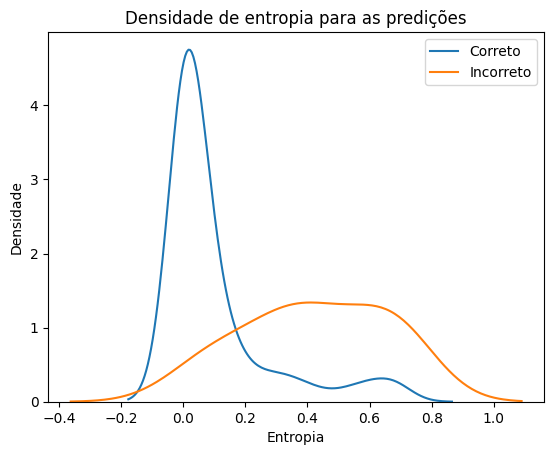

In [7]:
distribuicao_entropia(ytest, _MAP)

O modelo que utiliza a **Estimativa de Máximo a Posteriori** utiliza o $\theta$ que maximiza a posteriori. Portanto, como o único indicativo de incerteza em relação à predição é o próprio $\theta$ estimado pontualmente, não se trata de um modelo que quantifica bem a incerteza das predições, o que explica a alta densidade de probabilidade onde a entropia é próxima de 0 no caso das predições corretas - ou seja, quanto o modelo previu corretamente o resultado, ele tinha praticamente certeza a respeito da predição. No caso das predições incorretas, o modelo tinha mais dúvidas a respeito do resultado previsto.

2. **APROXIMAÇÃO DE LAPLACE**

A ideia é fazer uma aproximação simples $q(\theta)$ para a posteriori $p(\theta|\mathcal{D})$ usando uma expansão de Taylor de segunda ordem em $\log p(\theta|\mathcal{D})$ ao redor da moda da posteriori.

$$\log p(\theta|\mathcal{D}) \approx \log q(\theta) =  \dfrac{1}{2} (\theta - m)^T H(\theta - m) + \text{constante} \Rightarrow$$

$$q(\theta) \propto \exp(\dfrac{-1}{2} (\theta - m)^T H (\theta -m))$$

$$q(\theta) = \mathcal{N} (\theta| \mu = m, \sigma^2 = H^{-1})$$

A série de Taylor é então usada para aproximar a distribuição posteriori como uma distribuição normal ao redor da moda (o $\theta$ obtido na aplicação do MAP), com média igual à moda e variância dada pela inversa da Hessiana (que é a matriz de covariância da distribuição posteriori).

Em seguida, podemos usar a série de Taylor para aproximar a distribuição posteriori como uma distribuição normal ao redor da moda.

In [8]:
class AproxLaplace():
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        variancia_priori = 100 # variancia do priori
        
        n_samples = 10000 # numero de amostras para calcular a media da verossimilhança
        n_features = X.shape[1]
        
        self.theta = torch.randn(n_features, requires_grad=True)
        optimizer = torch.optim.Adam([self.theta], lr=self.learning_rate)
        
        for epoch in range(10000):
            optimizer.zero_grad()
                    
            logits = X @ self.theta
                    
            neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, y)
            log_priori = - MultivariateNormal(torch.zeros(n_features), variancia_priori * torch.eye(n_features)).log_prob(self.theta)
                    
            neg_log_posteriori = neg_log_likelihood + log_priori
                    
            neg_log_posteriori.backward()
            optimizer.step()
        
        hessian = torch.autograd.functional.hessian(lambda theta: F.binary_cross_entropy_with_logits(X @ theta, y) - MultivariateNormal(torch.zeros(n_features), variancia_priori * torch.eye(n_features)).log_prob(self.theta), 
                                                    self.theta)
        
        matriz_covariancia = torch.inverse(hessian)
        
        # distribuição posteriori ~ normal multivariada
        self.distribuicao_posteriori = np.random.multivariate_normal(self.theta.detach().numpy(), 
                                                                        matriz_covariancia.detach().numpy(), 
                                                                        size=n_samples)
    
    def predict(self, X):
        logits = X @ torch.tensor(self.distribuicao_posteriori).float().t()
        self.ypred = torch.sigmoid(logits)
        self.ypred = self.ypred.mean(axis=1)
        self.ypredRound = (self.ypred > 0.5)
        return self.ypredRound
    
    def accuracy(self, y):
        accuracy = (self.ypredRound == y).float().mean().item()
        return accuracy

In [9]:
_AproxLaplace = AproxLaplace()
_AproxLaplace.fit(Xtrain, ytrain)
ypredLaplace = _AproxLaplace.predict(Xtest)

print('Accuracy AproxLaplace:', _AproxLaplace.accuracy(ytest))

Accuracy AproxLaplace: 0.9251101613044739


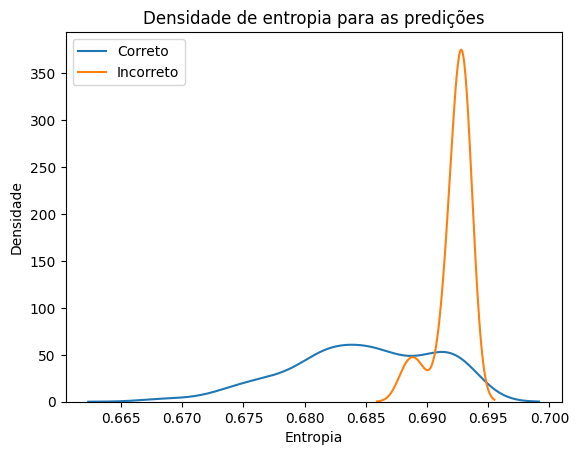

In [10]:
distribuicao_entropia(ytest, _AproxLaplace)

Diferente do Máximo a Posteriori, a Aproximação de Laplace inclui mecanismos mais eficazes de quantificação de incerteza em relação às predições. Em particular, como a teoria informa que aproximamos a distribuição da posteriori a partir de uma distribuição normal, a própria matriz de covariância (indexada na Normal como a variância da distribuição) pode ser usada para estimar a incerteza em torno do $\theta$ estimado pelo MAP.

No gráfico plotado acima, observamos o efeito da quantificação da incerteza. O modelo, na prática, tinha mais incerteza no que diz respeito ao resultado predito. No caso das predições incorretas, principalmente, o modelo estava mais incerto do resultado predito, apresentando valores de entropia maiores.

3. **INFERÊNCIA VARIACIONAL**

Novamente, a ideia é aproximar a posteriori $p(\theta|\mathcal{D})$ de uma distribuição mais simples. A diferença é que, ao invés de utilizar uma expansão de Taylor, queremos minimizar uma medida de discrepância para $p$ em relação à distribuição $q$, computada pela divergência de Kullback-Leibler (KL), notada por:

$$D_{KL} (q || p) = E_{\theta \sim q} \left[ \log \dfrac{q(\theta)}{p(\theta)} \right]$$

Em particular, queremos a distribuição $q$ que minimiza essa divergência. No nosso contexto, a distribuição $p(\theta)$ da fórmula é a posteriori $p(\theta|\mathcal{D})$. Portanto, podemos reescrever como:

$$D_{KL} ({q(\theta) || p(\theta|\mathcal{D})}) =$$

$$E_{\theta \sim q} \left[  \log \dfrac{q(\theta)}{\dfrac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})}}\right] =$$

$$E_{\theta \sim q}[\log q(\theta)] + E_{\theta \sim q}[\log p(\mathcal{D})] - E_{\theta \sim q}[\log p(\mathcal{D}|\theta)]$$

Já comentamos em outras ocasiões que $\log p(\mathcal{D})$ é constante em relação aos parâmetros do modelo, de modo que definimos $L(q)$ a ser maximizada (equivalente a minimizar $D_{KL}$):

$$L(q) = E_{\theta \sim q}[\log p(\theta|\mathcal{D})] - E_{\theta \sim q}[\log q(\theta)]$$

Escolhemos um espaço de parâmetros $\Omega$ que maximiza $L(q)$. Como desejamos aplicar um método de otimização, precisamos de uma forma simples de calcular o gradiente. Fazemos, para isso, uma aproximação utilizando amostragem, onde a ideia é utilizar uma variável aleatória que não depende de $\Omega$ (no caso, um ruído $\epsilon \sim N[0, 1]$) e aplicar à ela uma transformação $g$ que depende de $\Omega$. Definimos $g(\epsilon; (\mu, \sigma^2)) = \epsilon \sigma + \mu$. 

No caso, como o problema pede que utilizemos uma Gaussiana diagonal e não uma Gaussiana padrão. A diferença estará na dimensão de $\mu$ e $\sigma$. Além disso, precisamos aplicar uma função de ativação específica na variância, a $\texttt{Softplus}$. Essa transformação garante que a variância seja positiva em todas as situações, evitando a possibilidade de que ocorra um valor de variância negativo ou nulo, o que poderia levar a problemas durante a otimização do modelo.

In [11]:
class InfVariacional():
    
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        variancia_priori = 100 # variancia do priori
        
        n_samples = 10000 # numero de amostras para calcular a media da verossimilhança
        n_features = X.shape[1]
        
        mu = torch.randn(n_features, requires_grad=True)
        sigma = torch.randn(n_features, requires_grad=True)
        
        optimizer = torch.optim.Adam([mu, sigma], lr = 0.01) 
        
        for epoch in range(1000):
            optimizer.zero_grad()
            
            sigma_positivo = F.softplus(sigma)
            
            thetas = torch.randn(100, n_features) @ torch.diag(sigma_positivo) + mu
            
            loss = 0
            
            for sample in range(100):
                theta_sample = thetas[sample, :]
                logits = Xtrain @ theta_sample
                
                neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, y)
                log_priori = - MultivariateNormal(torch.zeros(n_features), variancia_priori * torch.eye(n_features)).log_prob(theta_sample)
                log_q = MultivariateNormal(mu, sigma_positivo * torch.eye(n_features)).log_prob(theta_sample)
                
                loss += (neg_log_likelihood + log_priori + log_q)/100
                
            loss.backward()
            optimizer.step()
        
        mu = mu.detach().numpy()
        sigma = (sigma_positivo).detach().numpy() * np.eye(n_features)
        
        self.distribuicao_posteriori = np.random.multivariate_normal(mu, sigma, size=n_samples)
        
    def predict(self, X):
        logits = X @ torch.tensor(self.distribuicao_posteriori).float().t()
        self.ypred = torch.sigmoid(logits)
        self.ypred = self.ypred.mean(axis=1)
        self.ypredRound = (self.ypred > 0.5)
        return self.ypredRound
    
    def accuracy(self, y):
        accuracy = (self.ypredRound == y).float().mean().item()
        return accuracy

In [12]:
_InfVariacional = InfVariacional()
_InfVariacional.fit(Xtrain, ytrain)
ypredInfVariacional = _InfVariacional.predict(Xtest)

print('Accuracy InfVariacional:', _InfVariacional.accuracy(ytest))

Accuracy InfVariacional: 0.8986784219741821


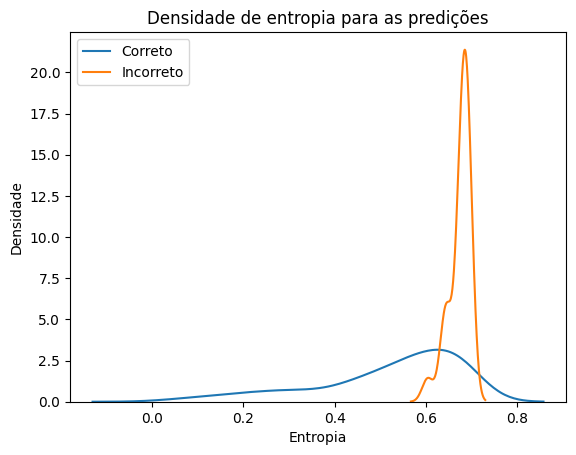

In [13]:
distribuicao_entropia(ytest, _InfVariacional)

A interpretação do gráfico acima é semelhante à interpretação dos resultados da Aproximação de Laplace. Isto é, trata-se de um modelo eficiente na quantificação de incerteza, de modo que o modelo tinha mais incerteza sobre o resultado predito principalmente no caso das previsões incorretas. Naturalmente, também havia maior incerteza em relação aos valores previstos corretamente, pelo menos em comparação ao MAP.

# Exercícios de "papel e caneta"

1. Derive a fórmula para a divergência KL entre duas distribuições Gaussianas univariada, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;

2. Suponha que $P$ é a família das distribuições categórica com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia? 

3. Use a desigualdade de Jensen para mostrar que a divergência KL é não-negativa.

4. Derive a aproximação de Laplace para a distribuição Beta($\alpha, \beta$). Mostre uma fórmula para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

5. Derive a posteriori para o modelo Bayesiano com verossimilhança Categórica e priori Dirichlet, i.e.:
\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.


### **SOLUÇÃO 1**

Tome-se a fórmula da divergência $D_{KL} = E_{\theta \sim q} \left[ \log \dfrac{q(\theta)}{p(\theta)} \right]$. 

Dadas as duas distribuições normais do problema, podemos reescrever a expressão da seguinte forma:

$$D_{KL} = E_{\theta \sim q} \left[ \log \left( \dfrac{\dfrac{1}{\sigma_1 \sqrt{2 \pi}} \exp (\dfrac{-1}{2}) (\dfrac{\theta - \mu_1}{\sigma_1})^2}{\dfrac{1}{\sigma_2 \sqrt{2 \pi}} \exp (\dfrac{-1}{2}) (\dfrac{\theta - \mu_2}{\sigma_2})^2}  \right)  \right]$$

Como estamos calculando o valor esperado em $q$, é importante ter em mente que $\theta$ diz respeito à função $q$. Isso será importante para as manipulações algébricas que faremos mais a frente.

A expressão segue conforme abaixo:

$$D_{KL} = E_{\theta \sim q} \left[ \log (\dfrac{\sigma_2}{\sigma_1}) - (\dfrac{1}{2}) (\dfrac{\theta - \mu_1}{\sigma_1})^2 + (\dfrac{1}{2}) (\dfrac{\theta - \mu_2}{\sigma_2})^2  \right] = $$

$$\log (\dfrac{\sigma_2}{\sigma_1}) + \dfrac{1}{2} E_{\theta \sim q} \left[  (\dfrac{\theta - \mu_2}{\sigma_2})^2 - (\dfrac{\theta - \mu_1}{\sigma_1})^2  \right] = $$

$$\log (\dfrac{\sigma_2}{\sigma_1}) + \dfrac{1}{2} E_{\theta \sim q} \left[  (\dfrac{\theta - \mu_2}{\sigma_2})^2 \right] - \dfrac{1}{2} E_{\theta \sim q} \left[  (\dfrac{\theta - \mu_1}{\sigma_1})^2 \right] = $$

$$ \log (\dfrac{\sigma_2}{\sigma_1}) + \dfrac{1}{2 \sigma^2_2} E_{\theta \sim q} \left[ \theta^2 - 2\theta \mu_2 + \mu^2_2 \right] - \dfrac{1}{2 \sigma^2_1} E_{\theta \sim q} \left[ \theta^2 - 2\theta \mu_1 + \mu^2_1 \right] = $$

Nessa passagem, precisamos lembrar da informação já mencionada de que $\theta$ diz respeito à função $q$. Assim, se, por exemplo, $-2 E_{\theta \sim q}[\theta \mu_1]$ pode ser escrito como $-2 \mu_1^2$, o mesmo não pode ser computado para $-2 E_{\theta \sim q}[\theta \mu_2]$, que na verdade é $-2 \mu_2 E_{\theta \sim q}[\theta]$. Com isso, a expressão se torna:

$$ \log (\dfrac{\sigma_2}{\sigma_1}) + \dfrac{1}{2\sigma_2^2}(\mu_1^2 + \sigma_1^2 - 2\mu_2 \mu_1 + \mu_2^2) - \dfrac{1}{2\sigma_1^2}(\mu_1^2 + \sigma_1^2 - 2\mu_1^2 + \mu_1^2) = $$

$$\log (\dfrac{\sigma_2}{\sigma_1}) + \dfrac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \dfrac{1}{2}$$

### **SOLUÇÃO 2**

Na prática, a distribuição categórica com suporte em $\{1,\ldots, L\}$ é uma distribuição discreta, ou seja, a probabilidade de cada um dos valores é 0, exceto para um único valor. Então, a distribuição com maior entropia é aquela onde as observações têm a mesma probabilidade de ocorrer, ou seja, a distribuição uniforme.

Conhecemos a fórmula da entropia e para encontrar a distribuição com maior entropia, basta maximizá-la. Assim, temos:

$$H(p) = - \sum_{l=1}^L p_l \log p_l$$

Aplicando Lagrange, temos:

$$\max_{p_l} \left\{ - \sum_{l=1}^L p_l \log p_l + \lambda \left( \sum_{l=1}^L p_l - 1 \right) \right\}$$

Calculando a derivada parcial em relação a $p_l$ e igualando a zero, temos:

$$\dfrac{\partial \mathcal{L}}{\partial p_l} = - \log p_l + \lambda - 1 = 0 \Rightarrow \exp(1 - \lambda) = p_l$$

Substituindo na equação de restrição, temos:

$$\sum_{l=1}^L \exp(1 - \lambda) = 1$$

Como $\lambda$ é uma constante, podemos isolar $\exp(1 - \lambda)$ e obter:

$$\exp(1 - \lambda) = \dfrac{1}{L} \Rightarrow \lambda = 1 - \log L$$

Esse resultado aplicado à derivada parcial em relação a $p_l$ nos dá:

$$- \log p_l + \lambda - 1 = 0 \Rightarrow - \log p_l + 1 - \log L - 1 = 0 \Rightarrow \log p_l = - \log L \Rightarrow p_l = \dfrac{1}{L}$$

Justamente, a distribuição uniforme, onde todas as observações têm a mesma probabilidade de ocorrer.

### **SOLUÇÃO 3**

A desigualdade de Jensen é uma desigualdade que diz que a função $f$ é convexa, ou seja, $f$ é crescente em $x$ e $y$ e $x \leq y$, então $f(x) \leq f(y)$. Vamos observar a divergência KL:

$$D_{KL}(q||p) = E_{\theta \sim q} \left[ \log \left( \dfrac{q(\theta)}{p(\theta)} \right) \right]$$

A divergência KL utiliza a função $f(x) = \log x$, mas como a função é côncava e a desigualdade de Jenssen, podemos reescrever a divergência KL como:

$$D_{KL}(p||q) = E_{\theta \sim q} \left[ - \log \left( \dfrac{p(\theta)}{q(\theta)} \right) \right]$$

Com isso, podemos aplicar a desigualdade de Jensen e obter:

$$ -\log E_{\theta \sim q} \left[ \dfrac{p(\theta)}{q(\theta)} \right] \leq E_{\theta \sim q} \left[ - \log \left( \dfrac{p(\theta)}{q(\theta)} \right) \right]$$

O cálculo do membro à esquerda é dado por uma integral, em particular:

$$-\log E_{\theta \sim q} \left[ \dfrac{p(\theta)}{q(\theta)} \right] = -\log \int q(\theta) \dfrac{p(\theta)}{q(\theta)} d\theta = -\log \int p(\theta) d\theta = -\log 1 = 0$$

Note que a integral é ponderada pela função $q(\theta)$, que é a distribuição de probabilidade que estamos utilizando para aproximar a distribuição de probabilidade $p(\theta)$ (Método de Monte Carlo).

Com isso, obtivemos o seguinte resultado:

$$0 \leq E_{\theta \sim q} \left[ - \log \left( \dfrac{p(\theta)}{q(\theta)} \right) \right],$$

de onde concluímos que a divergência KL é não-negativa.

### **SOLUÇÃO 4**

A ideia da aproximação de Laplace é aproximar uma determinada distribuição $p(\theta)$ por uma distribuição Gaussiana. Para isso, é necessário encontrar a média e a variância da distribuição Gaussiana que melhor aproxima a distribuição $p(\theta)$. Em particular, os parâmetros são dados pela moda $m$ e a variância $H^{-1}$ da distribuição $p(\theta)$, respectivamente, onde $H$ é a matriz Hessiana de $p(\theta)$ (e sua inversa é a matriz de covariâncias).

A moda de uma distribuição Beta é computada por:

$$m = \dfrac{\alpha - 1}{\alpha + \beta - 2}$$

A matriz Hessiana é dada por $- \nabla_\theta^2 -\log \text{pdf}$, onde a função de densidade de probabilidade é a distribuição Beta. Assim, a matriz Hessiana é dada por:

$$H = - \nabla_\theta^2 \log \dfrac{1}{B(\alpha, \beta)} \theta^{\alpha - 1} (1 - \theta)^{\beta - 1} $$

Vamos realizar o cálculo em etapas, iniciando pela primeira derivada:

$$H = - \nabla_\theta \left[ - \dfrac{\alpha - 1}{\theta} + \dfrac{\beta - 1}{1 - \theta} \right] $$

E, finalmente,

$$H = \dfrac{\alpha - 1}{\theta^2} + \dfrac{\beta - 1}{(1 - \theta)^2} $$

Como o $\theta$ utilizado nesse caso é justamente a moda, precisamos substituir o valor da moda na expressão acima. Assim, temos:

$$H = \dfrac{\alpha - 1}{m^2} + \dfrac{\beta - 1}{(1 - m)^2} = $$

$$\dfrac{\alpha - 1}{\left(\dfrac{\alpha - 1}{\alpha + \beta - 2}\right)^2} + \dfrac{\beta - 1}{\left(\dfrac{\beta - 1}{\alpha + \beta - 2}\right)^2} = $$

$$\dfrac{(\alpha + \beta - 2)^2}{\alpha - 1} + \dfrac{(\alpha + \beta -2)^2}{\beta - 1} = $$

$$ \dfrac{(\alpha + \beta - 2)^3}{(\alpha - 1)(\beta - 1)} $$

Naturalmente, a matriz de covariâncias é dada por $H^{-1}$, ou seja, $\dfrac{(\alpha - 1)(\beta - 1)}{(\alpha + \beta - 2)^3} $. 

Portanto, aproximando a distribuição Beta por uma distribuição Gaussiana, temos $\mathcal{N}(m, H^{-1})$. Para o caso particular onde $\alpha = \beta = 2$, temos $\mathcal{N}\left( \dfrac{2-1}{2+2-2}, \dfrac{(2-1)(2-1)}{(2+2-2)^3} \right)$, ou mais precisamente $\mathcal{N}\left( \dfrac{1}{2}, \dfrac{1}{8} \right)$.

### **SOLUÇÃO 5**

O processo de derivação de uma posteriori para pela Regra de Bayes, computada da seguinte forma:

$$p(\mathbf{\theta} | \mathbf{y}) = \dfrac{p(\mathbf{y} | \mathbf{\theta}) p(\mathbf{\theta})}{p(\mathbf{y})}$$

No caso do problema, temos que a verossimilhança é $Cat(\theta)$ e a priori é $Dir(\alpha)$. Assim, a posteriori é proporcional ao produto entre das duas distribuições:

$$p(\mathbf{\theta} | \mathbf{y}) \propto p(\mathbf{y} | \mathbf{\theta}) p(\mathbf{\theta})$$

Obtendo a fórmula da verossimilhança e da priori, poderemos derivar a posteriori e tentar descobrir qual a sua distribuição. No caso, a verossimilhança é:

$$p(\mathbf{y} | \mathbf{\theta}) = \prod_{j=1}^N \prod^k_{i = 1} \theta_{i}^{[y_j = k]}$$

Essa expressão pode ser reescrita de forma que o produtório de $i$ até $N$ seja substituído por um somatório de $i$ até $N$ aplicando uma função indicadora $[y_j = k]$:

$$\prod_{j=1}^N \prod^k_{i = 1} \theta_{i}^{[y_j = k]} = \prod^k_{i = 1} \theta_{i}^{ \sum_{j=1}^N I(y_j = k)}$$

Agora, avaliemos a priori:

$$p(\mathbf{\theta}) = \dfrac{1}{B(\alpha)} \prod^k_{i = 1} \theta_{i}^{\alpha - 1}$$

Acoplando as duas expressões, temos uma expressão que é proporcional à posteriori:

$$p(\mathbf{\theta} | \mathbf{y}) \propto \prod^k_{i = 1} \theta_{i}^{ \sum_{j=1}^N I(y_j = k)} \dfrac{1}{B(\alpha)} \prod^k_{i = 1} \theta_{i}^{\alpha - 1} $$

$$ p(\mathbf{\theta} | \mathbf{y}) \propto \dfrac{1}{B(\alpha)} \prod^k_{i = 1} \theta_{i}^{ \sum_{j=1}^N I(y_j = k)} \theta_{i}^{\alpha - 1} $$

$$ p(\mathbf{\theta} | \mathbf{y}) \propto \dfrac{1}{B(\alpha)} \prod^k_{i = 1} \theta_{i}^{ \sum_{j=1}^N I(y_j = k) + \alpha - 1} $$

Basta observar, portanto, que a posteriori é uma distribuição Dirichlet com parâmetros $\alpha + \sum_{j=1}^N I(y_j = k)$.